[__Experience: Implications of Roaming in Europe__](https://doi.org/10.1145/3241539.3241577)

rev. 1, 9 June 2019, [Andra Elena Lutu](mailto: andra.lutu@telefonica.com), Telefonica Research



__Reference:__
Anna Maria Mandalari, Andra Lutu, Ana Custura, Ali Safari Khatouni, Özgü Alay, Marcelo Bagnulo, Vaibhav Bajpai, Anna Brunstrom, Jörg Ott, Marco Mellia, and Gorry Fairhurst. 2018. *Experience: Implications of Roaming in Europe.* In Proceedings of the 24th Annual International Conference on Mobile Computing and Networking (MobiCom '18). ACM, New York, NY, USA, 179-189. DOI: https://doi.org/10.1145/3241539.3241577 

*__Abstract__*

*"Roam like at Home"* is the initiative of the European Commission (EC) to end the levy of extra charges when roaming within the European region.  As a result, people are ble to use data services more freely across Europe. However, the implications roaming solutions have on performance have not been carefully examined. This hyper-paper provides an in-depth characterization of the implications of international data roaming within Europe. We build a unique roaming measurement platform using 16 different mobile networks deployed in six countries across Europe. Using this platform, we measure different aspects of international roaming in 3G and 4G networks, including mobile network configuration, performance characteristics, and content discrimination.  We find that operators adopt common approaches to implementing roaming, resulting in additional latency penalties of __60ms__ or more, depending on geographical distance.   Considering content accessibility, roaming poses additional constraints that leads to only minimal deviations when accessing content in the original country. However, geographical restrictions in the visited country make the picture more complicated and less intuitive.


# Introduction 

International roaming allows mobile users to use their voice and data services when they are abroad. 
The European Commission (EC), in an effort to create a single digital market across the European Union (EU), has recently (as of June 2017) introduced a set of [regulatory decisions](https://ec.europa.eu/digital-single-market/en/news/new-rules-roaming-charges-and-open-internet) as part of the *Roam like Home* initiative. This initiative abolishes additional charges for users when they use voice and data services while roaming in EU.
In this setting, Mobile Network Operators (MNOs) are expected to deliver services with Quality of Service (QoS) properties similar to the ones a user experiences when at home.

To support roaming, MNOs commonly connect with each other through an IP Packet Exchange (IPX) network. An [IPX](https://www.gsma.com/newsroom/wp-content/uploads//IR.34-v13.0-1.pdf) can be described as a hub that interconnects MNOs over a private IP backbone network and is possibly run by a third party IPX provider. An IPX provider has connections to multiple network operators and thus enables each MNO to connect to other operators via a single point of contact. 

In Figure 1 below, we present a set of topology architectures that can be used for roaming in a mobile network, namely, home-routed roaming (HR), local breakout (LBO) and IPX hub breakout (IHBO). When a mobile node is at home (left, see Figure 1), the home user’s traffic will take a short path inside the network to reach a suitable Packet Data Network Gateway (PGW) to the Internet. The traffic of a roaming user (right, see Figure 1) is directed to an egress PGW whose location depends on the roaming architecture. In the case of HR, the mobile node receives the IP address from its home MNO and the roaming user’s traffic is first routed towards a PGW in the home network (red path). With LBO, the mobile node receives its IP address from the visited network and the traffic is routed towards a local PGW in the visited network (purple path). When using IHBO, the mobile node obtains its IP address from the IPX networks and the traffic is routed through a PGW in the IPX network (green path). The topology can have a potential impact on the communication performance. For instance, when the node accesses services inside the visited network, the performance is likely to be worse in the HR case, because all packets travel twice between the visited and the home country; less so when the communication peer is in a third country and is minimal when accessing services in the home country.

In [1]:
#print("Fig 1. Internet access options for a mobile node at home (left) and when roaming (right).")
from IPython.display import IFrame
IFrame("./resources/figs/roaming-configurations_3.pdf", width=700, height=450)

__Figure 1. Internet access options for a mobile node at home (left) and when roaming (right).__

In this paper, we perform an extensive [large-scale measurement study](https://www.it.uc3m.es/amandala/roaming.html) to understand the roaming ecosystem in Europe after the “Roam like Home” initiative. More specifically, we investigate: (i) *Which technical solutions are actually being
deployed and used today?* and (ii) *What are the implications of roaming on the service experienced by the roaming user?*

To address these questions, we built a unique measurement platform, __MONROE-Roaming__, to assess roaming and itsperformance implications. The platform integrates dedicated measurement hardware that we deployed in six different countries (see Fig. 2 and [Section 2](#MONROE-Roaming-and-Measurement-Setup) for details) across Europe, covering a total of 16 MNOs. We purchased Subscriber Identity Modules (SIMs) that support roaming for these MNOs and distribute them across the six countries. We characterize roaming operation and network performance ([Section 3](#Roaming-Setup-and-Performance)) and evaluate the impact on VoIP and web applications ([Section 4](#VOIP-and-Content-Discrimination)) while roaming. We find that all observed MNOs use HR, which yields noticeable latency increases. We do not observe traffic differentiation policies for VoIP or web, but we do find evidence of content discrimination for roaming users. We discuss the results of our study and the implications of roaming in [Section 5](#Discussion) and conclude the paper in [Section 6](#Conclusions).

## About this Notebook

This is a Jupyter notebook containing the analysis code used to generate its visualizations; it is, in a sense, a ["hyperpaper"](https://doi.org/10.1145/3314212.3314218). It depends on the other resources in this directory to download measurements from MONROE-Roaming and place them in distilled form, from which this paper reads data and generates visualizations and tables.

Run the following cells to set up the environment, import useful packages, define visualization functions, and load the dataframes from which this paper's analysis and visualization follow.

In [19]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import dateutil.parser as dp
from datetime import datetime
import requests
import os.path
import statsmodels.api as sm
import seaborn as sns
import csv
import os
import json

In [20]:
'''
A function that 
i) prints the number of non null objects
ii) plots a CDF for the objects that have data
'''
def plot_ecdf(data, **kwargs):
    d = data.dropna() # drop nas
    num_samples = len(d)
    #print ("%10s : %d non null samples"%(kwargs['label'], num_samples))
    if num_samples > 0 :
        ecdf = sm.distributions.ECDF(d)
        plt.plot(ecdf.x, ecdf.y, **kwargs)

In [21]:
# define helper function to generate heatmaps
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Arguments:
        data       : A 2D numpy array of shape (N,M)
        row_labels : A list or array of length N with the labels
                     for the rows
        col_labels : A list or array of length M with the labels
                     for the columns
    Optional arguments:
        ax         : A matplotlib.axes.Axes instance to which the heatmap
                     is plotted. If not provided, use current axes or
                     create a new one.
        cbar_kw    : A dictionary with arguments to
                     :meth:`matplotlib.Figure.colorbar`.
        cbarlabel  : The label for the colorbar
    All other arguments are directly passed on to the imshow call.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom", size=14)
    cbar.ax.tick_params(labelsize=12)

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False, labelsize = 'large',
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="left",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Arguments:
        im         : The AxesImage to be labeled.
    Optional arguments:
        data       : Data used to annotate. If None, the image's data is used.
        valfmt     : The format of the annotations inside the heatmap.
                     This should either use the string format method, e.g.
                     "$ {x:.2f}", or be a :class:`matplotlib.ticker.Formatter`.
        textcolors : A list or array of two color specifications. The first is
                     used for values below a threshold, the second for those
                     above.
        threshold  : Value in data units according to which the colors from
                     textcolors are applied. If None (the default) uses the
                     middle of the colormap as separation.

    Further arguments are passed on to the created text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[im.norm(data[i, j]) > threshold])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [22]:
def compute_cdf(a):
    sorted_x = [i for i in sorted(a.values())]
    sorted_x =  sorted(a.values())
    p = 1. * np.arange(len(sorted_x)) / (len(sorted_x) - 1)
    return sorted_x,p

def cdf_bitrates(op,call,ho,Ids):
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    Apps=df["App"].unique()
    Apps.sort()
    fig, ax = plt.subplots()
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    for i in Ids:
        for app in Apps:
            style=':'
            width=2
            if i ==0:
                style='-'
                width=2
                lab=app.title()+" snd."
                sub_df=df[(df["App"]==app ) &  ( df["ExpId"]==i ) & ( df["CallType"]==call ) & ( df["Outlier"]==0 ) ] 
            else:
                lab=app.title()+" rcv."	
                sub_df=df[(df["App"]==app ) &  ( df["ExpId"]==i ) & ( df["CallType"]==call ) & ( df["IMSIMCCMNC"]==op ) & ( df["Outlier"]==0 ) & ( df["Home"]==ho )] 

            for index, row in sub_df.iterrows():
                a = eval(row["Throughput"])
                sorted_x,p=compute_cdf(a)
                if i>216 :
                    lab=''

                lab=lab.replace("messanger","messenger")
                print (lab)
                ax.plot(sorted_x,p,linewidth=width,color=app_colors[app],linestyle=style,label=lab)
    plt.legend(loc='lower right',fontsize=17)
    plt.ylabel(r'ECDF',size=15)
    plt.xlabel(r'bit rate [kb/s]',size=15)
    plt.xlim([0,700000])
    plt.ylim([0,1])
    plt.xticks([0,100000,200000,300000,400000,500000,600000,700000],[0,100,200,300,400,500,600,700],fontsize=15)
    plt.yticks([0,0.2,0.4,0.6,0.8,1],[0,0.2,0.4,0.6,0.8,1],fontsize=15)
    plt.grid(True)
    plt.show()

def cdf_ipg(op,call,app,ho,Ids):
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    fig, ax = plt.subplots()
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    for i in Ids:
        if i==0:
            sub_df=df[(df["App"]==app ) &  ( df["ExpId"]==i ) & ( df["CallType"]==call ) & ( df["Outlier"]==0 ) ] 
        else:
            sub_df=df[(df["App"]==app ) &  ( df["ExpId"]==i ) & ( df["CallType"]==call ) & ( df["IMSIMCCMNC"]==op ) & ( df["Outlier"]==0 ) & ( df["Home"]==ho )] 
        for index, row in sub_df.iterrows():
            if row["NodeId"]!=0:
                color=colors[Nodes[str(row["NodeId"])]]
                style=':'
                width=2
                lab="Node in " + Nodes[str(row["NodeId"])] + " call " + "in " + Servers[row["Server"]]	
            else:
                color='black'
                style='-'
                width=3
                lab="Sender"
            a = eval(row["DeltaT"])
            sorted_x,p=compute_cdf(a)
            ax.plot(sorted_x,p,linewidth=width,color=color,linestyle=style,label=lab)
    plt.ylabel(r'ECDF',size=15)
    plt.xlabel(r'IPG [ms]',size=15)
    plt.legend(loc='upper left',fontsize=15)
    plt.xlim([-0.01,0.1])
    plt.ylim([0,1])
    plt.xticks([0,0.02,0.04,0.06,0.08,0.1],[0,20,40,60,80,100],fontsize=14)
    plt.yticks([0,0.2,0.4,0.6,0.8,1],[0,0.2,0.4,0.6,0.8,1],fontsize=14)
    plt.grid(True)
    plt.show()

def temporal_bitrate(op,call,app,ho,Ids):
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    fig, ax = plt.subplots()
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    for i in Ids:
        if i==0:
            sub_df=df[(df["App"]==app ) &  ( df["ExpId"]==i ) & ( df["CallType"]==call ) & ( df["Outlier"]==0 ) ] 
        else:
            sub_df=df[(df["App"]==app ) &  ( df["ExpId"]==i ) & ( df["CallType"]==call ) & ( df["IMSIMCCMNC"]==op ) & ( df["Outlier"]==0 ) & ( df["Home"]==ho )] 
        for index, row in sub_df.iterrows():
            if row["NodeId"]!=0:
                color=colors[Nodes[str(row["NodeId"])]]
                style=':'
                width=3
                lab="Node in " + Nodes[str(row["NodeId"])] + " call " + "receiver in " + Servers[row["Server"]]	
            else:
                color='black'
                style='-'
                width=2
                lab="Sender"
            a=list(eval(row["Throughput"]).values())
            ax.plot(range(len(a)),a,linewidth=width,color=color,linestyle=style,label=lab)
    plt.ylabel(r'bit rate [kb/s]',size=17)
    plt.xlabel(r'Time [s]',size=15)
    plt.legend(loc='lower center',fontsize=15)
    plt.ylim([0,600000])
    plt.xlim([0,80])
    plt.yticks([0,100000,200000,300000,400000,500000,600000],[0,100,200,300,400,500,600],fontsize=15)
    plt.xticks([0,10,20,30,40,50,60,70,80],[0,10,20,30,40,50,60,70,80],fontsize=15)
    plt.grid(True)
    plt.show()


def get_df(app,call,op,ho):
    if ho==2:
        sub_df=df[(df["App"]==app ) & ( df["CallType"]==call ) & ( df["IMSIMCCMNC"]==op ) & ( df["Outlier"]==0 ) ] 
    else:
        sub_df=df[(df["App"]==app ) & ( df["CallType"]==call ) & ( df["IMSIMCCMNC"]==op ) & ( df["Outlier"]==0 ) & ( df["Home"]==ho )] 
    return sub_df

def compute_average_Throughput_KS(app,call,op,ho):
    KS=[]
    PV=[]
    sub_df = get_df(app,call,op,ho)
    for index, row in sub_df.iterrows():
        KS.append(eval(row["Throughput_KS"])[0])
        PV.append(eval(row["Throughput_KS"])[1])
    return np.mean(KS),np.mean(PV)

def compute_average_DeltaT_KS(app,call,op,ho):
    KS=[]
    PV=[]
    sub_df = get_df(app,call,op,ho)
    for index, row in sub_df.iterrows():
        KS.append(eval(row["DeltaT_KS"])[0])
        PV.append(eval(row["DeltaT_KS"])[1])
    return np.mean(KS),np.mean(PV)

def scatter(fname):
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    fig, ax = plt.subplots()
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    for func in [compute_average_Throughput_KS,compute_average_DeltaT_KS]:
        m='*'
        color='r'
        if func == compute_average_Throughput_KS:
            m='o'
            color='b'
        Apps=df["App"].unique()
        Apps.sort()
        Calls=df["CallType"].unique()
        Calls.sort()
        Ops=df[df["IMSIMCCMNC"]!=0 ]["IMSIMCCMNC"].unique()
        Ops.sort()
        for h in [2]:
            f=fname
            Index = []
            Cols = []
            data = []
            for o in Ops:
                Index.append(IMSIMCCMNCs[o])
                for a in Apps:
                    for c in Calls:
                        k,p=func(a,c,o,h)
                        plt.scatter(k, p,marker=m,color=color, alpha=0.3)
            if h ==2:
                f+= ".pdf"  
            else:
                f+= "_visited.pdf" if h==0 else "_home.pdf"  
    plt.scatter([],[],marker='*',color='r',label='IPG')
    plt.scatter([], [],marker='o',color='b',label='bit rate')

    plt.ylabel(r'P-Value',size=15)
    plt.xlabel(r'KS statistic ',size=15)
    plt.legend(loc='upper right',fontsize=15)
    plt.xlim([0,0.4])
    plt.ylim([0,1])
    plt.xticks([0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40],fontsize=15)
    plt.yticks([0,0.2,0.4,0.6,0.8,1],[0,0.2,0.4,0.6,0.8,1],fontsize=15)
    plt.grid(True)
    plt.show()

In [16]:
# download the data files that we will use in this notebook for producing the visualizations and tables
# of the measurements
! curl -L https://www.dropbox.com/s/2yo8rlgsvc3zfk3/datasets.zip --output ./resources/datasets.zip
! unzip ./resources/datasets.zip -d ./resources/

Archive:  ./resources/datasets.zip
   creating: ./resources/datasets/
  inflating: ./resources/datasets/config.txt  
  inflating: ./resources/datasets/traceroute_parsed_data_all.csv  
  inflating: ./resources/datasets/http_parsed_data.csv  
  inflating: ./resources/datasets/dataframe_with_metrics.csv  
  inflating: ./resources/datasets/dns_parsed_data.csv  


# MONROE-Roaming and Measurement Setup

In this section, we present the hardware platform we built for roaming measurements, and the manner in which we orchestrate it to collect our data.

In [2]:
# print("Fig 2. The distribution (left) of the MONROE-Roaming nodes in six countries and (right) SIMs\
# for 16 MNOs we measure across Europe. Each country deploys two MONROE-Roaming nodes and one measurement server.")
from IPython.display import IFrame
IFrame("./resources/figs/monroe_distribution.png", width=600, height=300)

__Fig 2. The distribution (left) of the MONROE-Roaming nodes in six countries and (right) SIMs for 16 MNOs we measure across Europe. 
Each country deploys two MONROE-Roaming nodes and one measurement server.__

## MONROE-Roaming Platform

We design and build MONROE-Roaming, a dedicated platform for roaming measurements in Europe. MONROE-Roaming
integrates several components that we depict in Fig. 3. The main blocks include measurement nodes distributed in six different EU countries, the backend system, several measurement servers and a scheduler, all of which we detail next. To build the MONROE-Roaming platform we adapted the open source software provided by [MONROE](https://www.monroe-project.eu/access-monroe-platform/), an open measurement platform.

In [3]:
#<a id='Figure3'></a>
# print("Fig. 3. MONROE-Roaming platform and experimental setup. We exemplify our setup for Vodafone DE. \
# We have five Vodafone DE SIMs in international roaming nodes and another SIM in the home country nodes. \
# For each roaming Vodafone DE SIM,  we insert the SIM corresponding to the local roaming partner for the MNO.\
# For example, in Sweden we use the Telenor SE SIM which corresponds \
# to the network on which the Vodafone DE SIM is camping.")
from IPython.display import IFrame
IFrame("./resources/figs/systemdesign_v3.pdf", width=700, height=450)

__Fig. 3. MONROE-Roaming platform and experimental setup. We exemplify our setup for Vodafone DE.
We have five Vodafone DE SIMs in international roaming nodes and another SIM in the home country nodes.
For each roaming Vodafone DE SIM,  we insert the SIM corresponding to the local roaming partner for the MNO.
For example, in Sweden we use the Telenor SE SIM which corresponds to the network on which the Vodafone DE SIM is camping.__

__MONROE-Roaming nodes__: Each MONROE-Roaming node is equipped with an APU board from PC Engines with
two 3G/4G MC7455 LTE CAT6 miniPCI express modems. Because of the high cost of nodes and subscriptions, and the
complexity of the coordination effort required (see [Section 2.3](#Measurement-coordination)), we have set up a platform with a total of 12 MONROE-Roaming nodes dedicated for roaming measurements.

__MONROE-Roaming backend__: Upon completion of each measurement, MONROE-Roaming nodes transfer the measurement results to a central server for further analysis.

__Measurement servers__: We have deployed one measurement server in each country as measurement responders and also to capture traffic traces.

__MONROE-Roaming scheduler__: The scheduler allows the user to query for resources, select nodes and launch
different tests in the platform simultaneously. We used the open source MONROE scheduler as a basis for the MONROE-Roaming scheduler. Each test is designed and implemented in a [Docker container](http://dl.acm.org/citation.cfm?id=2600239.2600241).

<a id='Table1'></a>
__Table 1: Terminology__

|Paper Terminology|Definition|
|---|---|
|*Home network*|The network to which a mobile user subscribes.|
|*Home SIM*|The mobile user SIM while in the home country and connected to the home network.|
|*Visited Network*|The network to which a user connects while roaming internationally in the visited country.|
|*Visited SIM*|A mobile user SIM subscribed to the visited network in the visited country.|
|*Roaming User*|A user subscribed to a home network in country A and who is roaming in a foreign country B.|

## Experimental Setup

To understand the roaming ecosystem in Europe, we focus on diversity of the MNOs. In other words, we aim to cover
a large number of SIMs rather than running measurements from a large number of vantage points. To this end, we deployed two MONROE-Roaming nodes in each of the six European countries to measure a total of 16 MNOs that operate their own network, as illustrated in Figure 2.

For each MNO, we bought six SIMs that support roaming in Europe and we distributed one SIM in each of the countries
we cover. For example, in Germany, we bought six Vodafone DE SIMs that support roaming. We kept one Vodafone DE
SIM as the home SIM in the home country (i.e., Germany). Then, we distributed five roaming SIMs from Vodafone DE to
the other five countries (i.e, Sweden, Norway, UK, Italy and Spain). Each roaming SIM connects to (or camps on) a local roaming partner (or visited network) native to the visited country. For example, Vodafone DE in Germany is a roaming partner of Telenor SE in Sweden. Therefore, Telenor SE serves Vodafone DE’s customers roaming in Sweden by allowing Vodafone DE users to camp on Telenor SE’s network. For each roaming SIM, we identify the corresponding visited network (e.g., Telenor SE in Sweden for Vodafone DE) and, when available, activate the corresponding native SIM from the visited network (which we hereinafter denote by visited SIM). We illustrate this configuration in the experimental setup in Figure 3. We also describe the terminology in [Table 1](#Table1) above.

## Measurement Coordination

Each MNO-specific measurement campaign involves 11 SIMs and 6 nodes: (i) one node with the home SIM and (ii) five
nodes with both the roaming SIM and the corresponding visited SIM, as illustrated in Figure 3. This enables us to capture performance metrics for the roaming SIM, but also to compare those with the local performance of the home network and the visited network (when possible).
Before running the set of measurements (see [Section 3](#Roaming-Setup-and-Performance) and [Section 4](#VOIP-and-Content-Discrimination)), we first need to configure the nodes by activating and deploying the SIMs. For each MNO, we perform the measurements at the same time from all six countries and coordinate the configuration of the experimental setup in two steps:

__Home and Roaming User Activation:__ To measure an MNO, we first insert the SIM into the first SIM slot in each node in all six deployment locations. For the SIM active in its home country, this step triggers the home user activation (by inserting the SIM in the measurement node). For the rest of the nodes, this step triggers the roaming user activation.

__Visited User Activation:__ Once we complete the home and roaming user activation, we check which visited network
the roaming SIM uses in each of the five visited countries. Then, we insert the SIM of each partner MNO (when available) into the second slot of each corresponding node.

Using the MONROE-Roaming scheduler, we orchestrate the execution of the measurements so that they run in parallel
on all nodes. The measurement coordination effort was a significant part of the process. In each country, at least one person was dedicated to carry out the physical experimental setup configuration for each MNO in a timely manner. Given that we deploy two nodes per country, we could measure two MNOs and (maximum) 22 SIMs in parallel. We coordinated the SIM changes over email. Furthermore, before the change of the next pair of SIMs, we double-checked the measurement results we had collected to ensure correctness and completeness of the dataset. Each round lasted one week, over a total period of more than four months of experiments.

# Roaming Setup and Performance

## Measurements

We run a series of measurements that enable us to identify the roaming setup, infer the network configuration for
the 16 MNOs that we measure and quantify the end-user performance for the roaming configurations which we detect.
We run *traceroute* for path discovery, *dig* for Domain Name Service (DNS) lookups and curl for testing data transfers with popular URLs. We complement this analysis with metadata (e.g., radio access technology, signal strength parameters) collected from each node.

For each MNO, we measure in parallel the roaming user, the home user and the visited user (see [Section 2](#MONROE-Roaming-and-Measurement-Setup) for terminology) through the MONROE-Roaming scheduler. In this way, we are able to capture potential performance penalties that might result, for example, from roaming internationally under a home-routed configuration. We performed measurements using both 3G and 4G networks to evaluate the impact of potentially different configurations for the two radio access technologies.

Next, we describe each measurement test and its resulting dataset in more details.

__traceroute__: We run periodic traceroute measurements against all the servers we deploy in each country as measurement responders. We repeat the measurements ten times towards each target. The resulting dataset lists the set of IP hops along the data paths from each vantage point towards each measurement responder. Additionally, we collect the public mapped IP address for each vantage point (i.e., the IP endpoint associated with the mobile client as seen from the public Internet).

In [23]:
# read the dataset containing the results of all the traceroute measurements 

# DATA DICTIONARY
# country = physical location of the MONROE-Roaming nodes running the measurements
# node_id = unique ID of the MONROE-Roaming hardware nodes that we used for running our measurements
# operator = tag for showing the operator we measure; the ones with "_home" tag are in native mode, while the rest are in roaming
# filepath = location of the json measurement files as retrieved from the measurement nodes 
# target = IP address of the measurements responder (the server we deploy per country) 
# NWMCCMNC = the MCC/MNC codes as read from the radio network to which the SIM attaches
# IMSIMCCMNC = the MCC/MNC codes as read from the SIM card, belonging to the MNO that owns the SIM 
# num_private_ip = the number of hops with private IPv4 addresses on the trace path to the target
# dis_target = the number of hops from the vantage point until the target 
# rtt_first_ip = the RTT against the fist hop the replied our traceroute probes on the path to the target
# rtt_target = the RRT from the vantage point to the target
# num_public_ip_first_AS = the number of hops with a public IP address within the autonomous system of the mobile node (the SIM we measure) 
# first_private_ip = the first private IP on the path to the target in our measurements
# num_private_ip.1 = the number of different IP addresses associated to the first hop on the path to the target
# first_public_ip = the first public IP mapped to the mobile node (the SIM card we measure)
# public_ip_list = the full list of public mapped IP addresses to the mobile node
# num_public_ip = the number of different public mapped IP addresses to the mobile node 

traces = pd.read_csv("./resources/datasets/traceroute_parsed_data_all.csv", sep = ";")

In [24]:
# We process the traceroute results we read above to tag the following for setups for the traceroute measurements: 

# Measurement Origin --> Measurement Target
# -------------------------------------------
# RTT_A: Roaming SIM --> Visited Server  # roaming = 0 and target_CC == visited_CC
# RTT_B: Roaming SIM --> Home Server     # roaming = 0 and target_CC == home_CC
# RTT_C: Visited SIM --> Home Server     # roaming = 1 and target_CC == home_CC
# RTT_D: Visited SIM --> Visited Server  # roaming = 1 and target_CC == visited_CC 

server_CC = {"193.10.227.25":"SE", "163.117.253.6":"ES", "130.192.181.137":"IT", "139.133.232.22":"UK",\
             "131.159.24.230":"DE", "141.40.254.120":"DE", "128.39.37.161":"NO"}
MCC_CC = {240:"SE", 214:"ES", 222:"IT", 234:"UK", 242:"NO", 262:"DE"}

In [25]:
# we add an additional column to show the country code (CC) of the target server
traces["target_CC"] = traces.target.apply(lambda x: server_CC[str(x)] )

# we add an additional column to show that the record (traceroute measurement) was \
# taken when the SIM was roaming (value = 0) or at home (value = 1)
traces["visited_CC"] = traces.NWMCCMNC.astype(str).str[:3].apply(lambda x: MCC_CC[int(x)] )
traces["home_CC"] = traces.IMSIMCCMNC.astype(str).str[:3].apply(lambda x: MCC_CC[int(x)] )

traces['roaming'] = (traces["visited_CC"]==traces["home_CC"]).astype(int)
traces = traces[traces.rtt_target<300]

In [26]:
# plot CDF of the rtt_target values we measure from each SIM in the four different senarios 
RTT_A = traces[(traces['roaming']==0) & (traces['target_CC']==traces['visited_CC'])].rtt_target # # roaming = 0 and target_CC == visited_CC
RTT_B = traces[(traces['roaming']==0) & (traces['target_CC']==traces['home_CC'])].rtt_target # roaming = 0 and target_CC == home_CC
RTT_C = traces[(traces['roaming']==1) & (traces['target_CC']!=traces['home_CC'])].rtt_target # roaming = 1 and target_CC != home_CC
RTT_D = traces[(traces['roaming']==1) & (traces['target_CC']==traces['home_CC'])].rtt_target # roaming = 1 and target_CC == home_CC

__dig__: We run the *dig* utility for DNS lookups against a list of 180 target Fully Qualified Domain Names (FQDNs) mapped to advertisement services. We use the independent filter lists from https://filterlists.com to build the list of targets. We focus on ad services because this type of third party services inflates significantly performance metrics of web services (e.g., page load time) and significantly [impacts the web experience of mobile users](https://doi.org/10.1007/978-3-319-54328-4_11). Thus, it is important to captute
(and potentially eliminate) any additional delay penalty that might impact how fast a roaming user receives this type of content. Each experiment uses the default DNS server for the tested MNO and queries for the A record associated to each of the target FQDNs. We store the entire output of each *dig* query, including the query time, the DNS server used and the A record retrieved. We repeat the *dig* queries 2 times for each FQDN from each vantage point, for a total of more than 2,000 queries per round.

In [27]:
# read the dataset containing the results of all the traceroute measurements 

# DATA DICTIONARY
# Iccid = The unique identifier number of the SIM card we use for measurements
# Operator = the Home Operator of the SIM card we use
# NodeId = unique ID of the MONROE-Roaming hardware nodes that we used for running our measurements
# IMSIMCCMNC = the MCC/MNC codes as read from the SIM card, belonging to the MNO that owns the SIM 
# NWMCCMNC = the MCC/MNC codes as read from the radio network to which the SIM attaches
# RAT = the radio access technology we use for our measurements
# publicIP = the public mapped IP address to the SIM card we use for our measurements
# ABP_target = the FQDN that we aim top resolve
# msgsize 
# Timestamp 
# queryTime = the delay it takes to receive the response from the DNS server
# server = the server returning the reply to the DNS resolve request
# A_record = the retrieved record from the DNS server 
# TTL = time to live for the A record resource retrieved 
# fqdn = fully qualified domain name
# city = the geo-location at the city level of the A record retrieved based on maxmind geo-location DB
# CC = country code of the A record retrieved based on maxmind geo-location DB
# GPS_loc = GPS coordinates ( latitude, longitude) for the A record location based on maxmind geo-location DB 

dns = pd.read_csv("./resources/datasets/dns_parsed_data.csv", sep = ";")

__curl__: We run curl towards a set of 10 target popular webpages over HTTP1.1/TLS. We repeat the measurements towards each URL at least 10 times (increasing the sample size if the SIM data quota allows it). We store various metrics, including the download speed, the size of the download, the total time of the test, the time to first byte, the name lookup time (query time) and the handshake time.
We target the following web pages: www.httpvshttps.com, facebook.com/telia/, en.wikipedia.org/wiki/Timeline_of_the_far_future, linkedin.com/company/facebook, www.yahoo.com/movies, instagram.com/leomessi/,
google.com/search?q=iPhone+7, youtube.com/watch?v=xGJ5a7uIZ1g, ebay.com/globaldeals, nytimes.com, theguardian.com.uk/lifeandstyle

In [28]:
http = pd.read_csv("./resources/datasets/http_parsed_data.csv", sep = ";", header=1)

__metadata__: We collect contextual information from the nodes, including the visited network Mobile Country Code
(MCC) / Mobile Network Code (MNC) for each roaming SIM and the radio technology. This allows us to verify which
visited network each roaming SIM uses as well as to identify and separate the collected data by radio technology.

## Roaming Configuration

Our initial goal is to determine the roaming setup for each MNO (i.e., whether it used LBO, HR or IHBO). 
For this, we determine the MNO that allocates the public IP address of the roaming SIM. 
__Our results show that HR was used by all 16 MNOs from all the different roaming locations we capture.__ 
We further corroborate this result by retrieving the first hop replying with a public IP address along the data path from a roaming SIM to each server and identifying the MNO that owns it. 
We find that the first hop with a public IP address along the path lies in the original home network of each roaming SIM, which is consistent with HR roaming.

Next, we evaluate the following performance metrics for each roaming SIM, home SIM and visited SIM: (i) the number of visited networks we observe for the roaming SIM, (ii) the number of hops from vantage point to target measurement server, (iii) the number of home network PGWs that the roaming SIMs reach in comparison with the home network SIMs. 

__Visited network selection:__ The metadata we collect during the measurement campaign for each MNO enables us
to verify the visited network that each roaming user camps on in the visited country. In general, we note stability both in 4G roaming and 3G roaming in the selection of the visited network ([Table 2](#Table2)) in the five roaming locations. We also observe some differences between MNOs. For example, for Telekom DE, the 4G visited network chosen by each roaming SIM never changed during the measurement campaign, even when we forced the radio technology handover. This is consistent for all the five roaming locations. For O2 DE, on the other hand, the default 4G visited network did change over time for the SIMs roaming in Italy (3 visited networks), Norway (3 visited networks), and Sweden (2 visited networks). However, it should be noted that the length of the measurement period varies for each MNO, as it is impacted by multiple external factors (e.g., at times some of our measurement responders were affected by power outages or some SIM cards were not connecting to the 4G network due to poor coverage). This may explain or influence part of the differences observed between the MNOs.

__Traceroutes, number of hops:__ We analyze our collected traceroute results from the roaming SIMs and compare with the traceroute results we collect from the corresponding home SIM towards the same target server. For all MNOs we find that the number of hops is the same. Note that traceroute for 3 IT did not work in any country against any of the target servers. This is consistent with the HR configuration (Fig. 1), where the GTP tunnel is defined between the SGW of the visited network and the PGW of the home network.

<a id='Table2'></a>
__Table 2: Distribution of the first IP interface and visited network per MNO.We report the number of networks each roaming user camps on in the visited country (# of visited networks), the number of unique first IP addresses (# IP addr.), the total number of traceroutes we ran for the corresponding SIM (# tests) and the distribution for each first IP address we find (First hop breakdown(%)).__

|MNO|# of visited networks (3G, 4G)|# IP addr.|# tests|First hop breakdown(%)|
|---|---|---|---|---|
|O2 DE|(9, 9)|20|657|1; 1; 1; 2; 2; 2; 2; 2; 3; 3; 3; 4; 4; 5; 6; 6; 9; 9; 11; 24|
|Telekom DE|(5,5)|4|1424|13; 19; 25; 43|
|Voda DE|(5,6)|2|1511|46; 54|
|Movistar ES|(6, 6)|8|282|4; 5; 5; 7; 8; 21; 22; 28|
|Orange ES|(7, 7)|3|900|6; 43; 51|
|Voda ES|(5, 5)|1|1943|100|
|TIM IT|(6, 6)|4|497|1; 1; 46; 52|
|Voda IT|(5, 5)|4|759|19; 19; 23; 39|
|Telenor NO|(5, 5)|3|398|8; 30; 62|
|Telia NO|(5, 5)|4|379|7; 16; 38; 39|
|3 SE|(7, 6)|2|828|44; 56|
|Telenor SE|(5, 5)|2|1362|32; 68|
|Telia SE|(5, 5)|4|379|7; 16; 38; 39|
|EE UK|(5, 5)|9|1038|3; 4; 4; 5; 8; 13; 17; 19; 27|
|Voda UK|(5, 5)|1|503|100|



__Traceroutes, infrastructure:__ By learning the IP addresses of the infrastructure elements along the data path, we are able to infer aspects of the infrastructure deployment strategy of each MNO. In particular, by checking the IP address of the first hop in the path ([Table 2](#Table2)), we find that MNOs have different strategies in terms of their deployments. We note that the first hops have an even distribution on their assignation to mobile users, showing that the MNOs have a similar approach for load balancing in their network. For example, for O2 DE we find 20 different first hops, suggesting that there might be a large number of PGWs deployed in the LTE infrastructure, while for Vodafone UK we see that the same first hop appears on the data path, suggesting that the GTP tunnels of all our roaming users is terminated at a single PGW. We also note that although for the majority of MNOs, these hops are configured with private address space, three operators (Telekom DE, Telenor NO and Telenor SE) use public address space for their infrastructure. The last column in [Table 2](#Table2) details the breakdown of measurements among the number of different first hop IP addresses found. In some cases, a clear bias exists.

Finally, we verify that the set of first hops for roaming SIMs is the same as the set we observe from the home SIMs. This suggests that the roaming SIMs do not receive any differential treatment in terms of allocation to the PGWs. This is consistent for all MNOs we measure. Furthermore, when checking the 3G data paths, we find that the set of IP addresseswe see in 3G is a subset of the set of IP addresseswe see in 4G, suggesting that [the two functions are co-located in the same PGW](http://doi.acm.org/10.1145/3143361.3143369). We also check the time when the first IP address was used. We discover that all the PGWs are active in the same time. Multiple first IP addresses can be used at different time. We further contacted 3 MNOs and the information they provided about their network confirms our findings.

## Home-Routed Roaming: Implications

__Delay implications:__ The HR data implies that the roaming user’s exit point to the Internet is always in the original home network (Fig. 1). Thus, the data that the roaming user consumes always flow through the home network. Depending on the location of the server, this translates to a potential delay penalty. 

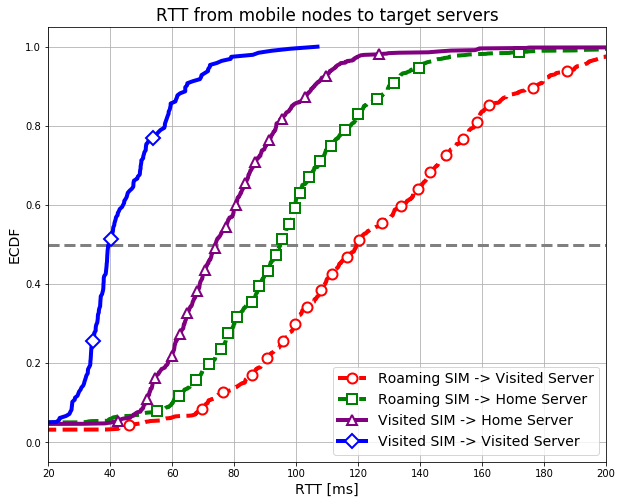

Fig. 4: ECDF of the RTT from mobile nodes to target servers.


In [29]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
plt.clf()
plt.style.context('seaborn-notebook')
marker_style = dict(markersize=10, markerfacecolor="white", markevery = 50, markeredgewidth=2)
plot_ecdf(RTT_A, color = 'r', linestyle = "--", linewidth=4, marker = "o", **marker_style)
plot_ecdf(RTT_B, color = 'g', linestyle = "--", linewidth=4, marker = "s", **marker_style)
plot_ecdf(RTT_C, color = 'purple', linestyle = "-", linewidth=4, marker = "^", **marker_style)
plot_ecdf(RTT_D, color = 'b', linestyle = "-", linewidth=4, marker = "D", **marker_style)

plt.hlines(0.5, 20, 200, linestyles='dashed', color = 'gray', linewidth=3)

plt.grid()
plt.xlim(20, 200)
plt.rcParams.update({'font.size': 14})
plt.xlabel("RTT [ms]", fontsize = 14)
plt.ylabel("ECDF", fontsize = 14)
plt.legend(["Roaming SIM -> Visited Server", "Roaming SIM -> Home Server", 
            "Visited SIM -> Home Server", "Visited SIM -> Visited Server"])
plt.title("RTT from mobile nodes to target servers")
plt.show()
print("Fig. 4: ECDF of the RTT from mobile nodes to target servers.")

Fig. 4 shows the ECDF of the RTT we measured between the roaming SIMs and the target servers located in the visited or home networks (red and green curves, respectively). To compare the HR with the LBO configuration, we also include the RTT measurements between the visited SIMs against the same targets in the visited or home networks (blue and purple curves, respectively). The RTTs experienced by the visited SIMs serve as estimates of the best RTTs that one could expect with a LBO configuration, since LBO relies on access to local infrastructure with no need for tunnelling back to the home network. We note that the largest delay penalty occurs when the roaming user tries to access a server located in the visited country. This is because the packets must go back and forth from the home network. Surprisingly, we note that the HR configuration also impacts the case when the roaming user accesses a target server located in the home network. That is, the GTP tunnel is slower than the native Internet path. In this case, the median value of the delay penalty considering all the MNOs is approximately 17ms. This varies across MNOs and in some cases we observe very low penalties (e.g., just 0.2ms for O2 Germany).

We investigate this performance impact further and calculate the estimated delay penalty between LBO and HR when the target is in the visited network. In more detail, we compute the delay penalty as the difference between the median delay to reach a given server when roaming, and the median delay to reach the same server from home. 

In [687]:
# get the baseline values against which we calculate the delay penalty 
# these are all for non-roaming SIMs, to show the penalty of using a SIM that is roaming with HR roaming config
# and not having a LBO roaming configuration in the visited country 

base = traces[traces["roaming"] == 1][["visited_CC", "target_CC", "rtt_target"]].groupby(["visited_CC", "target_CC"]).median()
base.reset_index(inplace=True)
base.columns = ['visited_CC', 'target_CC', 'base_rtt']

# filter only the values for DE
#base_DE = base.loc[base.visited_CC=='DE', ['target_CC', "base_rtt"]]

In [688]:
# plot here Figure 5.a. from the paper
# separate the measurements from Vodafone DE, MCCMNC = 26202 while roaming 

voda_DE = traces[(traces["IMSIMCCMNC"]==26202) & (traces["roaming"] == 0)][["rtt_target", "target_CC", "visited_CC"]]

In [689]:
voda_DE = voda_DE.groupby(["visited_CC", "target_CC"]).median()
voda_DE.reset_index(inplace=True)
voda_DE = pd.merge(voda_DE, base, on=("visited_CC", "target_CC"))
# calculat the delay penalty of the roaming configuration using HR roaming
voda_DE['rtt_diff'] = voda_DE['rtt_target'] - voda_DE['base_rtt']

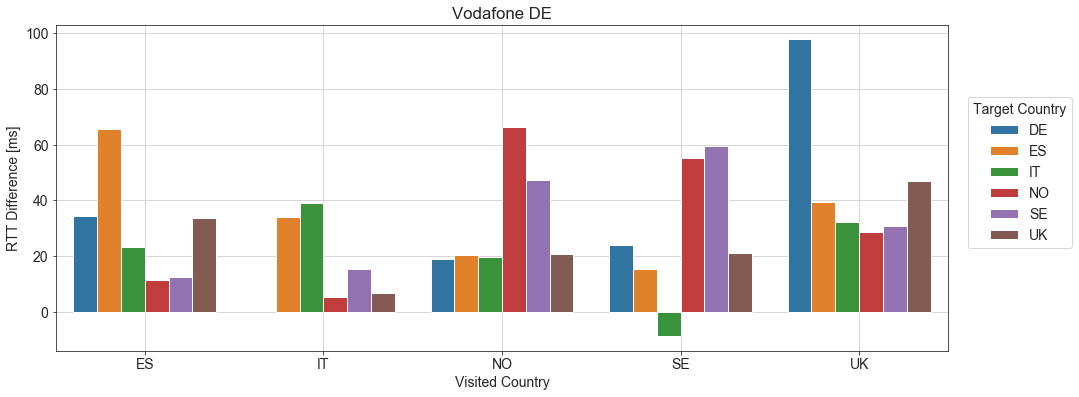

Fig. 5.a: RTT penalty from the visited country to all servers for Vodafone DE.      The penalty is the difference between the median RTT from SIMs in roaming and      the RTT from visiting SIMs towards the same target server.


In [690]:
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(16, 6)
sns.barplot(y = voda_DE.rtt_diff, x = voda_DE.visited_CC, hue=voda_DE.target_CC)
plt.title("Vodafone DE")
plt.xlabel("Visited Country")
plt.ylabel("RTT Difference [ms]")
plt.legend(title = "Target Country", loc='upper center', bbox_to_anchor=(1.08, 0.8))
plt.grid()
plt.show()

print("Fig. 5.a: RTT penalty from the visited country to all servers for Vodafone DE.\
      The penalty is the difference between the median RTT from SIMs in roaming and\
      the RTT from visiting SIMs towards the same target server.")


Fig. 5a exemplifies these median values for Vodafone Germany. We note that, in general, the delay penalty varies widely with the geographical location of the roaming users and the target servers. For example, when a German SIM roams in Spain, the difference in terms of RTT is higher if the server is in the visited country (i.e., Spain), which corresponds to the red curve in Fig. 4. If the German SIM roams in Spain or Italy and the target server is in Norway or Sweden the delay penalty of the roaming is smaller, since to go to Norway or Sweden the data path would anyway likely pass through Germany (and this is similar to the delay one would have because of the HR configuration).

In [691]:
roaming = traces[traces["roaming"] == 0][["rtt_target", "target_CC", "visited_CC", "IMSIMCCMNC"]]
roaming = roaming.groupby(["IMSIMCCMNC", "target_CC"]).median()
roaming.reset_index(inplace=True)

In [692]:
base = traces[traces["roaming"] == 1][["target_CC", "rtt_target", "IMSIMCCMNC"]].groupby(["IMSIMCCMNC", "target_CC"]).median()
base.reset_index(inplace=True)
base.columns = ['IMSIMCCMNC', 'target_CC', 'rtt_base']


In [693]:
roaming = pd.merge(roaming, base, on=("IMSIMCCMNC", "target_CC"))
roaming["rtt_diff"] = roaming["rtt_target"] - roaming["rtt_base"]

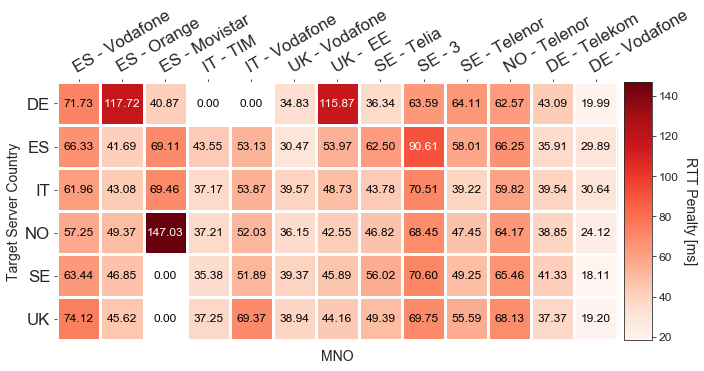

In [694]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib 
import warnings
warnings.filterwarnings("ignore")

df = roaming.groupby(["target_CC", "IMSIMCCMNC"])["rtt_diff"].sum()
data = df.unstack(level=1)
data = data.values

# category_labels = ["21401", "21403", "21407", "22201", "22210", "23415", "23430", "24001", "24002",
#        "24008", "24201", "26201", "26202"]
category_labels = ["ES - Vodafone", "ES - Orange", "ES - Movistar", "IT - TIM", "IT - Vodafone", "UK - Vodafone", 
                   "UK -  EE", "SE - Telia", "SE - 3", "SE - Telenor", "NO - Telenor", "DE - Telekom", "DE - Vodafone"]
series_labels = ['DE', 'ES', 'IT', 'NO', 'SE', 'UK']

fig, ax = plt.subplots(figsize=(10, 10)) 

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.09)
im, cbar = heatmap(data, series_labels, category_labels, ax=ax, 
                   cbar_kw={'cax':cax}, cmap="Reds", cbarlabel="RTT Penalty [ms]")
                   
texts = annotate_heatmap(im, valfmt="{x:.2f}", size = 12)
ax.set_ylabel("Target Server Country" ,fontsize = 14)
ax.set_xlabel("MNO", fontsize=14)
fig.tight_layout()
plt.show()

__Figure 5b__: RTT difference per operator for each target server. 

We then evaluate the RTT difference between the roaming SIM and the visited SIM towards the same target and we
group them per MNO. 
__Fig. 5b__ above shows the median value of the delay penalty of an MNO (on the x axis of the tile plot)
while roaming against each of the six different servers (on the y axis of the tile plot, marked by country). We note that the delay penalty varies as a function of the location of the home country. For example, German SIMs experience a lower delay penalty, which is potentially due to them being in an advantageous position in the center of Europe.

__DNS implications:__ The results of the dig measurements show that the DNS server offered to a roaming user is the same as the one offered when at home. This is again consistent with the use of HR. We verify whether this translates into an inflated query time for the roaming user. 

In [695]:
# separate the DNS measurements we did only for TIM IT 
dns["visited_CC"] = dns.NWMCCMNC.astype(str).str[:3].apply(lambda x: MCC_CC[int(x)] )
dns["home_CC"] = dns.IMSIMCCMNC.astype(str).str[:3].apply(lambda x: MCC_CC[int(x)] )
dns['roaming'] = (dns["visited_CC"]==dns["home_CC"]).astype(int)

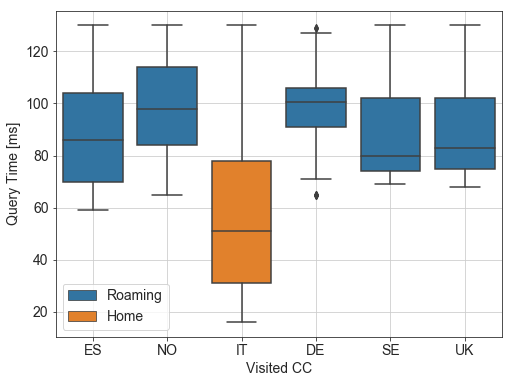

In [696]:
df = dns[(dns.queryTime<=130)&(dns.IMSIMCCMNC==22201)&(dns.RAT=="4G")] # separate only the samples from IT SIMs
df = df.assign(roaming=df.roaming.map({0: "Roaming", 1: "Home"}))

sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(8, 6)
sns.boxplot(y=df.queryTime, x=df.visited_CC, hue = df.roaming, dodge=False)
#ax = sns.swarmplot(y=df.queryTime, x=df.visited_CC, color=".25")
plt.grid()
plt.xlabel("Visited CC")
plt.ylabel("Query Time [ms]")
plt.legend(title = False)
plt.show()

__Fig 5.c:__ DNS Query time to all FQDNs for TIM IT.

__Fig. 5c__ presents the distribution of DNS query times for all the SIMs of TIM IT. We note that for the home user the query time is significantly lower in average than for the other five roaming users. This is consistent for all the 16 MNOs we measured. This further translates into implications in terms of CDN replica selection: the roaming user would be likely redirected to CDN content at its home network, and will not be able to access the same content from a local cache (which would in any case result in facing a higher delay due to the home routing policy).

__HTTP performance implications:__ Similar to the delay and DNS implications, international roaming affects HTTP and HTTPS performance.We quantify this penalty by considering the handshake time between each SIM and the target
web servers. The median value of the handshake time from the visited SIMs towards all the targets we measure is 170ms, while the median value for the roaming SIMs is 230ms. This leads to a delay penalty of approximately 60ms. As in the cases before, some MNOs are affected more by this roaming effect than others.

# VOIP and Content Discrimination

## VoIP Call

This section investigates potential traffic differentiation policies (such as blocking or throttling) that may hamper Voice over IP (VoIP) communications for a roaming user in comparison to a home user. We focus on three popular VoIP applications: FaceTime, Facebook Messenger, and Whatsapp.

__Experiment Design.__ We begin with checking whether the MNO allows successful audio/video VoIP calls by carrying
out some manual experiments with smart phone running the original applications and making calls among roaming
SIMs. This lets us verify possible filtering or blocking in plac at the time of the test. If successful, we then check for traffic differentiation mechanisms that could affect the call quality. The experiment makes three audio and video calls using each application running on a regular mobile phone connected using an instrumented WLAN access point (AP) in our lab. Packet traces were recorded using tcpdump resulting in 18 traces, each with duration between (60, 80) s. We verify the call-setup phase, which used a complex mix of TCP, STUN, and custom protocols to setup the end-to-end communication. From each trace, we then extract the actual audio/video streams. In the next step, we create a Docker container with pre-loaded traces, which we replay using tcpreplay to properly edit them so that packets are directed toward dedicated receivers hosted in our premises. All applications run SRTP on top of UDP, enabling easy adjustment of the packet timing and updating of the source and destination IP addresses. The dedicated server in each country acts as a UDP receiver with a custom signalling TCP connection to log the status of the node (visited network, node identifier, metadata, experiment type, etc.) and the experiment associated with the receiver. In each test, the mobile node sequentially replays the pre-recorded traces with two receivers: a call to a destination in the home country, and a call to a destination in the visited country. For each call, we record pcap traces on both the client and server sides. We post-process these traces to check for traffic differentiation.

In [698]:
df=pd.read_csv('./resources/datasets/dataframe_with_metrics.csv')
config=eval(open("./resources/datasets/config.txt",'r').readline())
IMSIMCCMNCs=config['IMSIMCCMNCs']
colors=config['colors']
Nodes=config['Nodes']
Servers=config['Servers']
app_colors={'facetime':'r', 'fbmessanger':'b', 'whatsapp':"g"}

__Results.__ We first verify that calls can be freely made from
the tested network. We found that all operators allow users
(even when roaming) to freely make VoIP calls using popular
applications on their smart-phone. This confirms that no
filtering was in place at the time of testing.
Next, we consider eventual traffic differentiation. We analyze
well-known QoS metrics for real-time VoIP applications:
packet loss, instantaneous bit rate, and Inter-Packet Gap
(IPG), the time difference between two consecutive packets,
to detect traffic differentiation. The results show that the
packet loss ratio is less than 1% in all experiments. We conclude
that no operators introduce artificial packet loss during
our tests. MNOs could do so if desired to reduce the quality
of calls for these applications and enforce traffic policing.
For each trace, we compare the bit rate we observe at the
sender side and at the receiver side. 

__Fig. 6a__ presents this as an
ECDF for the three applications. Solid/dashed lines indicate
the sender/receiver side when calling a receiver in the home
or visited country (operator O2 DE). The applications use
different audio/video codec combinations with different bit 
rate requirements. We observe no differences when using
the tested network and the home network.

Facetime snd.
Fbmessenger snd.
Whatsapp snd.
Facetime rcv.
Fbmessenger rcv.
Whatsapp rcv.

















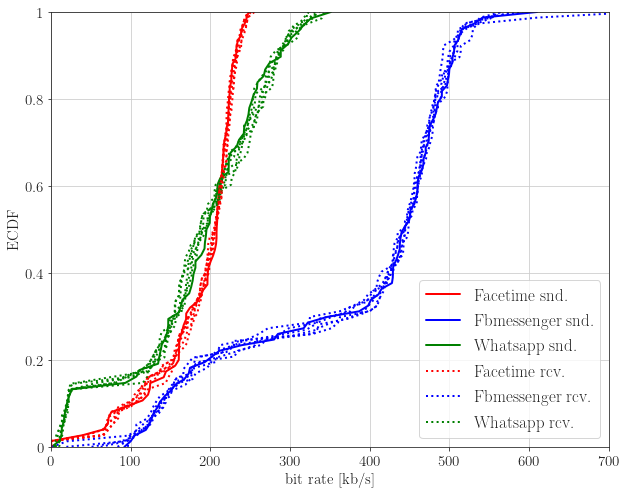

In [731]:
cdf_bitrates(26207,'video',1,[0,216, 217, 218, 220, 222, 223])

__Fig. 6b__ shows a mobile user of the O2 DE operator making a Facetime call to our server in Germany while roaming.
The periodic 60 ms long IPG is typical of low rate audio codecs the modern VoIP applications use. We observe some differences when comparing measurements at the sender (solid line) and the receiver (dashed lines – one for each
visited country). Some gaps are compressed (a smaller IPG), while others become expanded (a larger IPG). We observe
this in all experiments with all operators when the sender is in its home country.
We ascribe this to the modulation of the IPG by 3G/4G access mechanisms. Given the IPG is bounded to less than 80 ms, we conclude that this would not hamper voice quality, and expect these variations to be absorbed by the receiver playout buffer.

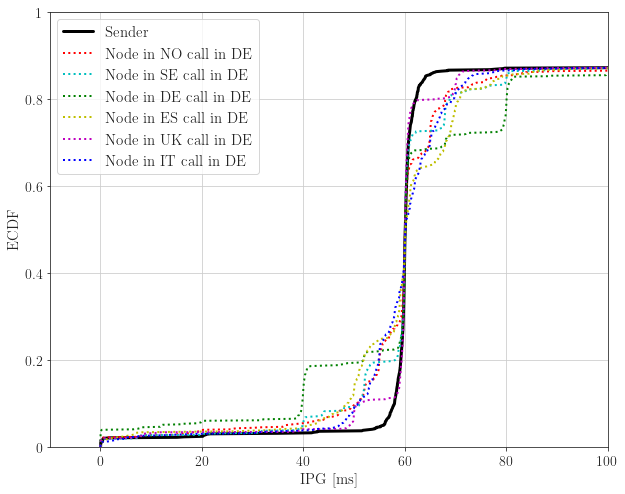

In [732]:
cdf_ipg(26207,'audio','facetime',1,[0,216, 217, 218, 220, 222, 223])

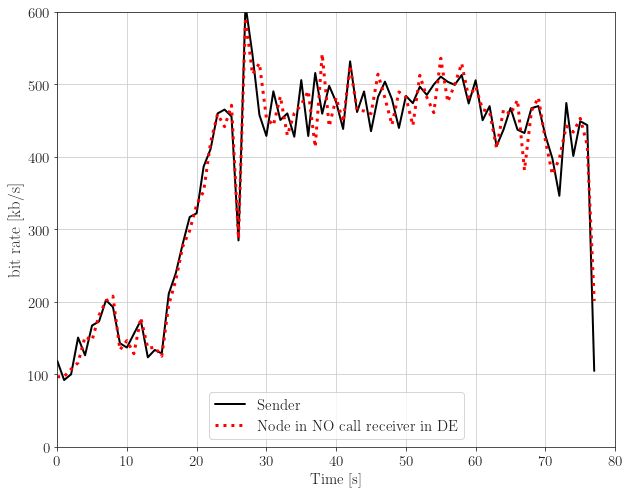

In [728]:
temporal_bitrate(26207,'video','fbmessanger',1,[0,216])

All experiments give very similar results, pointing to no evidence of traffic manipulation. We summarize these findings using the well-known [KS Test](https://doi.org/10.1007/978-0-387-32833-1_214) and [P-Value](https://doi.org/10.1080/00031305.2016.1154108) to determine whether the ECDFs differ between the sender (our reference) and the receiver. If statistically similar, the KS would be close to 0 while P-Value would be close to 1. If significantly different, the KS would be greater than 0, and the P-Value close to 0. 

__Fig. 6c__ shows the scatter plot of the (KS, P-Value) points. Our results confirm that the receiver throughput is statistically identical to the sender throughput in all experiments. The IPG statistics are affected by the 3G/4G access mechanisms that alter the distribution (albeit not impairing the VoIP quality).

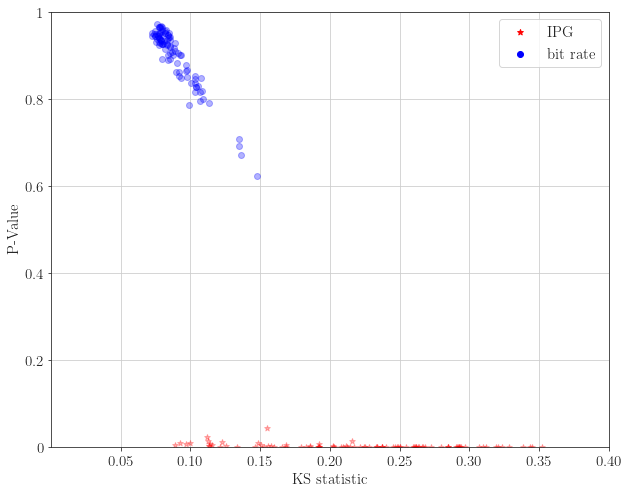

In [733]:
scatter("td_scatter_KS")

Finally, while QoS in terms of IPG and throughput are good, the total end-to-end delay could be significantly higher
when roaming because of the HR solution. The one-waydelay could thus grow excessively large when two roaming SIMs call each other, making the interactive voice conversation difficult. The same effect was faced in GSM networks, and fixed by [anti-tromboning](https://tools.ietf.org/html/draft-aoun-midcom-intrarealmcalls-00) solution (e.g., allowing local breakout for voice traffic).

__Takeaway.__ We do not observe any traffic differentiation
on any of the 16 MNOs we measure. However, the additional
delay of HR could impair real-time applications. This is an
old issue (typically referred to as tromboning) which has
been solved in GSM networks, but persists for 3G/4G VoIP
applications.

## Content Discrimination

In this section, we evaluate the availability of content when roaming, in particular whether MNOs filter website content and apply geographical restrictions. There are many reasons operators could have content filtering, which include complying with government guidelines or following court orders (e.g, to restrict access to file-sharing websites in the UK) or the use of ’opt-out’ parental filters. 
We refer to any differences in the availability of websites and their content due to network interference as "content discrimination". When this difference is attributed to geographical location rather than the studied network, it is known as "content geo-restriction".

# Discussion

## On Measurements Limitations

The MONROE-Roaming platform integrates measurement nodes located in six different EU countries and a measurement
responder per country. Although this allows us to capture at an unprecedented scale the performance of international
roaming in Europe, it is still a limited view in terms of spatial sample distribution within each country (we only
use two hardware devices per country, in the same location). Similarly, the findings in this paper refer to just one snapshot – and the community should repeat these experiments over time to identify and investigate changes. The high cost of mounting such an experimental study is a major restricting factor for the density of sampling geo-locations. We instead focus on characterizing multiple MNOs by taking advantage of the SIM farm we built using MONROE-Roaming. For each MNO, we purchased a similar data plan (10GB/month) enabling us to capture similar number of samples per MNO
and country. Furthermore, using the same equipment type throughout the measurement platform and in all locations
eliminates potential device bias we might observe in the measurement samples.

Our measurement study focuses mainly on network performance and content implications of the roaming solutions
in Europe.We leave for future work the exploration of potential performance penalties (see [Section 3.1](#Measurements)) on actual end-user Quality of Experience (QoE).

## On Roaming Configurations

LBO appears a natural choice for an IP-based service and could offer lower operational cost as well as cheaper data tariffs. At the same time, we have shown that this can eliminate delay and potentially increase capacity for some traffic (depending on the destination). Although, LBO relies on access to local infrastructure, offering this could act as a product differentiator for the MNOs that provide this service first. In contrast, HR provides the home MNOs with all the accounting and billing information. This has been verified to be the major problem with MNOs that need to have near real-time view of the customer traffic for accounting reasons.

Whereas Session Initiation Protocol (SIP) signalling could be used to derive billing information for voice (and VoLTE) calls, an MNO typically uses records to issue bills. Breakout at different points complicates this accounting, with possible abuse from customers (e.g, the delay in billing might allow excessive amount of data traffic when roaming). Within the cellular network, classes of traffic can be differentiated using the Access Point Name (APN) and QoS Class Identifier (QCI). This could be used, for instance, by MNOs to implement HR for data, but LBO for VoLTE. This raises the question of whether the roaming agreement could be updated using the same principle to break out some/all data traffic.

Any additional complexity from LBO can add to the operational cost of supporting users of the network (e.g., debugging issues, tracking faults, and predicting traffic). And if a service fails, it is not obvious who is responsible for finding the fault and fixing this. An IPX can help mitigate these impacts. Some solutions introduce additional proxy elects, responsible for routing traffic towards the correct network, and the associated control functions to coordinate.

Additionally, there are filtering rules, Digital Rights Management (DRM), language preference and personal content
that depend upon the location (country) in which the content is viewed. Lawful intercept further complicates the picture. Here, the home network has full visibility of the necessary data, but the visited network may not. Lawful intercept may be further complicated because of variations in regulatory requirements depending on the geographic location of equipment. In a nutshell, enforcing and accounting for multiple policies for different content in different locations can become complex. Home routing simplifies this by letting the original operator see and manage all the traffic.

# Conclusions

While roaming internationally, different network configuration options can affect performance of various applications
for the end user. In practice, although there are three possible solutions (i.e., HR, LBO or IHBO), we find that HR is the norm for the MNOs we measured. This comes with performance penalties on the roaming user, who experiences
increased delay and appears to the public internet as being connected in the home country. This has further implications in the selection of Content Delivery Network (CDN) server replica when roaming abroad, because the mobile user will access a server in the home network rather than one close to their location. However, at the same time, the roaming user is still able to access (in majority of cases) the geo-restricted services from the home country in her native language.

We put these results in perspective while trying to also speculate on the commercial implications of the “Roam like
use in their country under permanent roaming conditions.use in their country under permanent roaming conditions.use in their country under permanent roaming conditions.use in their country under permanent roaming conditions.use in their country under permanent roaming conditions.use in their country under permanent roaming conditions.use in their country under permanent roaming conditions.use in their country under permanent roaming conditions.Home” initiative. As regulation reduces the ability of MNOs to compete on price, the subscribers’ quality of experience will potentially become a key factor in choosing a provider. The subscribers will increasingly start to compare the roaming experience to the home experience. Thus, an expectation of high quality, always-on services in a visited network follows and if a home network fails to deliver in the visited network, the risk of churn increases. To this end, LBO is a natural step for an IP-based service, and could offer lower operational cost, and cheaper tariffs for data, while at the same time we have shown this can eliminate delay and potentially increase capacity for some traffic (dependent on the destination). Although LBO relies on access to the infrastructure of the visited network which can have implications on service control and charging, offering this could act in the advantage of the first operators to provide the service. Furthermore, in some cases, under the “Roam like Home” paradigm, some users may purchase SIMs from abroad to use in their country under permanent roaming conditions.

__Acknowledgements:__
This work has been partially supported by the European Union H2020-ICT grants 644399 (MONROE) and 688421 (MAMI),  H2020 project MONROE/CGNWatcher, the 5G-City project (TEC2016-76795-C6-3-R), H2020 project 5G-Range (777137). Part of this research was supported by Bayrisches Wissenschaftsforum (BayWISS) in the context of the Verbundkolleg “Mobilität und Verkehr”.